## Data Preparation

Split the data into training and testing data

In [1]:
import pandas as pd

df = pd.read_csv('../datasets/bordeaux.csv',
                 index_col="year")
df_train = df.loc[:1980].copy()
df_test = df.loc[1981:].copy()

In [2]:
df

,price,summer,har,sep,win,age
year,,,,,,
1952,37.0,17.1,160,14.3,600,40
1953,63.0,16.7,80,17.3,690,39
1955,45.0,17.1,130,16.8,502,37
1957,22.0,16.1,110,16.2,420,35
1958,18.0,16.4,187,19.1,582,34
1959,66.0,17.5,187,18.7,485,33
1960,14.0,16.4,290,15.8,763,32
1961,100.0,17.3,38,20.4,830,31
1962,33.0,16.3,52,17.2,697,30


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, metric="euclidean"))
X_train = df_train[["win", "summer"]]
y_train = df_train["price"]

- We evaluate our model's accuracy on multiple data points using Scikit-learn's cross_val_score function
- Fit a 5-nearest neighbors (euclidean metric) model to the training data and use the model to predict the labels on the testing data

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="neg_mean_squared_error",
    cv=4)
-scores.mean()

375.27166666666665

## Model Selection

What input features should we include?

- winter rain, summer temp
- winter rain, summer temp, harvest rain
- winter rain, summer temp, harvest rain, Sept. temp

In [4]:
for features in [["win", "summer"],
                 ["win", "summer", "har"],
                 ["win", "summer", "har", "sep"]]:
  scores = cross_val_score(
      pipeline,
      X=df_train[features],
      y=df_train["price"],
      scoring="neg_mean_squared_error",
      cv=4)
  print(features, -scores.mean())

['win', 'summer'] 375.27166666666665
['win', 'summer', 'har'] 363.04047619047617
['win', 'summer', 'har', 'sep'] 402.4507142857142


## Hyperparameter Tuning

What is the best value of $k$?

In [13]:
X_train = df_train[["win", "summer", "har"]]

ks, train_mses = range(1, 7), []
for k in ks:
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k, metric="euclidean"))
  scores = cross_val_score(
      pipeline, X_train, y_train,
      scoring="neg_mean_squared_error", cv=4)
  train_mses.append(-scores.mean())

Train Error

Text(0, 0.5, 'Train MSE')

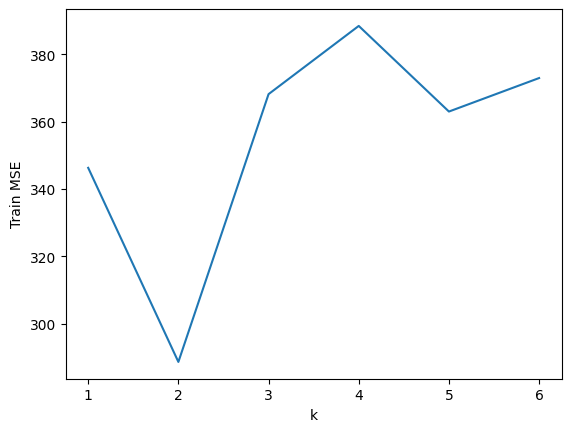

In [15]:
ax = pd.Series(train_mses, index=ks).plot.line()
ax.set_xlabel("k")
ax.set_ylabel("Train MSE")

## Grid Search

Scikit-Learn can make a grid of the possible parameter combinations, run cross-validation for each combination, and return the best parameter combination

In [16]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(
    pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(1, 7),
        "kneighborsregressor__metric": ["euclidean", "manhattan"],
    },
    scoring="neg_mean_squared_error", cv=4)

grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'kneighborsregressor__metric': 'euclidean',
 'kneighborsregressor__n_neighbors': 2}